# 初始化Spark环境

Python版本

In [1]:
!python -V

Python 3.11.5


In [2]:
import os

In [3]:
print(f"java:{os.environ['JAVA_HOME']}\nscala:{os.environ['SCALA_HOME']}\nHADOOP:{os.environ['HADOOP_HOME']}\nSPARK:{os.environ['SPARK_HOME']}")

java:D:\Spark_local\jdk1.8.0_251
scala:D:\Spark_local\scala-2.12.14
HADOOP:C:\spark_setup\spark-3.4.2-bin-hadoop3\hadoop
SPARK:C:\spark_setup\spark-3.4.2-bin-hadoop3


In [4]:
# 对于高版本python（3.11）需要高版本spark与之配套
# os.environ["SPARK_HOME"] = R"F:\spark_local\spark-3.4.2-bin-hadoop3"
# os.environ["HADOOP_HOME"] = R"F:\spark_local\hadoop-3.3.5"

In [5]:
# ! pip install -i https://pypi.douban.com/simple findspark

In [6]:
import findspark
findspark.init() # 将pyspark相关库添加到python环境中

In [7]:
# 导入Spark应用入口
from pyspark.sql import SparkSession # spark2.x及更高版本
# from pyspark import SparkContext  # Spark1.x

In [8]:
#初始化spark上下文
spark = (
         SparkSession
         .builder
#        .master("spark://192.168.2.123:7077") # 程序运行环境
         .master("local[4]")                   # 如果有集群，这里填写集群资源信息。例如：spark://192.168.2.123:7077
         .appName("SparkCoreDemo")
#        .config("youkey","youvalue") \
#        .config('spark.dynamicAllocation.enabled',True)\ 开启动态分配资源
#        .config('spark.dynamicAllocation.initialExecutors',1)\ 动态分配初始executor个数默认值
#        .config('spark.dynamicAllocation.minExecutors',1)\ 最少分配1个
#        .config('spark.dynamicAllocation.maxExecutors',12)\ 最多分配12个
#        .config('spark.executor.memory','12G') \ # 设置每个执行器 内存大小
#        .config('spark.executor.cores','4') \ # 设置每个执行器 CPU核数 
         .getOrCreate()
        )

In [9]:
sc = spark.sparkContext

In [10]:
sc.setLogLevel('ERROR') # 设置日志输出等级

In [11]:
sc.master

'local[4]'

In [12]:
spark.version

'3.4.2'

In [13]:
# spark.stop() # 释放资源

# RDD

## RDD创建
### 基于内存对象创建

In [14]:
rdd1=sc.parallelize([("A",23),("B",24),("C",29)])

In [15]:
rdd1

ParallelCollectionRDD[0] at readRDDFromFile at PythonRDD.scala:287

In [16]:
# collect 可以将RDD转换为python对象
rdd1.collect()

[('A', 23), ('B', 24), ('C', 29)]

In [17]:
# 查看分区数
rdd1.getNumPartitions() # 默认与app的CPU核数相关

4

In [18]:
rdd2=sc.parallelize([("A",23),("B",24),("C",29)],3)
rdd2.getNumPartitions()

3

In [19]:
rdd2.glom().collect() # 获取各个分区的数据内容

[[('A', 23)], [('B', 24)], [('C', 29)]]

### 从文件中获取

In [20]:
# 读取文件属于转换操作
RDD_A = sc.textFile("./data/A.txt")
RDD_B = sc.textFile("./data/B.txt")

In [21]:
RDD_B

./data/B.txt MapPartitionsRDD[6] at textFile at NativeMethodAccessorImpl.java:0

In [22]:
RDD_A.collect()

['13722222222 c',
 '13622222222 b',
 '13722222222 c',
 '13733333333 c ',
 '13622222222 c']

In [23]:
RDD_B.collect()

['13722222222 c',
 '13522222222 b',
 '13722222222 b',
 '13733333333 b',
 '13622222222 c']

## Transformation操作

- map(func):对RDD中的每个element都使用func，返回一个新的RDD 
- filter(func) : 对RDD中的每个元素都使用func，返回每个执行func为true的元素构成的RDD 
- flatMap(func):和map差不多，但是flatMap生成的是多个结果,扁平化的结果。
- mapPartitions(func):和map很像，但是map是每个element，而mapPartitions是每个partition
- mapPartitionsWithSplit(func):和mapPartitions很像，但是func作用的是其中一个split上，所以func中应该有index 
- sample(withReplacement,faction,seed):抽样
- union(otherDataset)：返回一个新的dataset，包含源dataset和给定dataset的元素的集合
- distinct([numTasks]):返回一个新的dataset，这个dataset含有的是源dataset中的distinct的element
- groupByKey(numTasks):返回(K,Seq[V])，也就是hadoop中reduce函数接受的key-valuelist
- reduceByKey(func,[numTasks]):就是用一个给定的reduce func再作用在groupByKey产生的(K,Seq[V]),比如求和，求平均数
- sortByKey([ascending],[numTasks]):按照key来进行排序，是升序还是降序，ascending是boolean类型 
- join(otherDataset,[numTasks]):当有两个KV的dataset(K,V)和(K,W)，返回的是(K,(V,W))的dataset,numTasks为并发的任务数
- cogroup(otherDataset,[numTasks]):当有两个KV的dataset(K,V)和(K,W)，返回的是(K,Seq[V],Seq[W])的dataset,numTasks 为并发的任务数
- cartesian(otherDataset)：笛卡尔积 

选取常用的Transformation 进行讲解

### map
实现数据的迭代转换，传入的函数接受的参数为RDD中的每个元素

In [24]:
RDD_A.map(lambda x:x.upper()).collect()

['13722222222 C',
 '13622222222 B',
 '13722222222 C',
 '13733333333 C ',
 '13622222222 C']

### filter
实现数据的过滤筛选，传入的函数接受的参数为rdd的每个元素，函数的返回值必须为布尔型

In [25]:
# 筛选RDD_A最后一个字符是C的数据
RDD_A.filter(lambda x:x[-1]=="c").collect()

['13722222222 c', '13722222222 c', '13622222222 c']

### flatMap

会将每次返回的结果扁平化，例如：map 返回的 是 [1,2]  那么flatmap返回的是1，2

In [26]:
words=["Python hadoop spark","Python hadoop java","Python scala spark"]
rdd_words = sc.parallelize(words)

In [27]:
# 将各个单词拆开
rdd_words.map(lambda x:x.split()).collect()

[['Python', 'hadoop', 'spark'],
 ['Python', 'hadoop', 'java'],
 ['Python', 'scala', 'spark']]

In [28]:
rdd_words.map(lambda x:x.split()).count()

3

In [29]:
# 将每个单词放到一个列表上
rdd_words.flatMap(lambda x:x.split()).collect()

['Python',
 'hadoop',
 'spark',
 'Python',
 'hadoop',
 'java',
 'Python',
 'scala',
 'spark']

In [30]:
rdd_words.flatMap(lambda x:x.split()).count()

9

### union 合并RDD

In [31]:
AB = RDD_A.union(RDD_B)
AB.collect()

['13722222222 c',
 '13622222222 b',
 '13722222222 c',
 '13733333333 c ',
 '13622222222 c',
 '13722222222 c',
 '13522222222 b',
 '13722222222 b',
 '13733333333 b',
 '13622222222 c']

### join 合并RDD 内连接

In [32]:
RDD_A.join(RDD_B).collect()

[('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3')),
 ('1', ('3', '3'))]

In [33]:
RDD_A.map(lambda x:x.strip().split()).collect()

[['13722222222', 'c'],
 ['13622222222', 'b'],
 ['13722222222', 'c'],
 ['13733333333', 'c'],
 ['13622222222', 'c']]

In [34]:
RDD_B.map(lambda x:x.strip().split()).collect()

[['13722222222', 'c'],
 ['13522222222', 'b'],
 ['13722222222', 'b'],
 ['13733333333', 'b'],
 ['13622222222', 'c']]

In [35]:
RDD_A.map(lambda x:x.strip().split()).join(
RDD_B.map(lambda x:x.strip().split())
).collect()

[('13733333333', ('c', 'b')),
 ('13722222222', ('c', 'c')),
 ('13722222222', ('c', 'b')),
 ('13722222222', ('c', 'c')),
 ('13722222222', ('c', 'b')),
 ('13622222222', ('b', 'c')),
 ('13622222222', ('c', 'c'))]

### reduceByKey文件去重问题
将AB 中的元素去重

In [36]:
AB.distinct().collect()

['13722222222 c',
 '13622222222 c',
 '13722222222 b',
 '13622222222 b',
 '13733333333 c ',
 '13522222222 b',
 '13733333333 b']

In [37]:
AB.map(lambda x:[x,0]).collect()

[['13722222222 c', 0],
 ['13622222222 b', 0],
 ['13722222222 c', 0],
 ['13733333333 c ', 0],
 ['13622222222 c', 0],
 ['13722222222 c', 0],
 ['13522222222 b', 0],
 ['13722222222 b', 0],
 ['13733333333 b', 0],
 ['13622222222 c', 0]]

In [38]:
AB.map(lambda x:[x,0]).reduceByKey(lambda x,y:x).collect()

[('13722222222 c', 0),
 ('13622222222 c', 0),
 ('13722222222 b', 0),
 ('13622222222 b', 0),
 ('13733333333 c ', 0),
 ('13522222222 b', 0),
 ('13733333333 b', 0)]

In [39]:
AB.map(lambda x:[x,0]).reduceByKey(lambda x,y:x).map(lambda x:x[0]).collect()

['13722222222 c',
 '13622222222 c',
 '13722222222 b',
 '13622222222 b',
 '13733333333 c ',
 '13522222222 b',
 '13733333333 b']

reduce的计算逻辑
[1,2,3,4]  lambda x,y:x+y
- 1,2  -> 3
- 3,3  -> 6
- 6,4 -> 10

Hadoop 的 MapReduce 处理代码：     

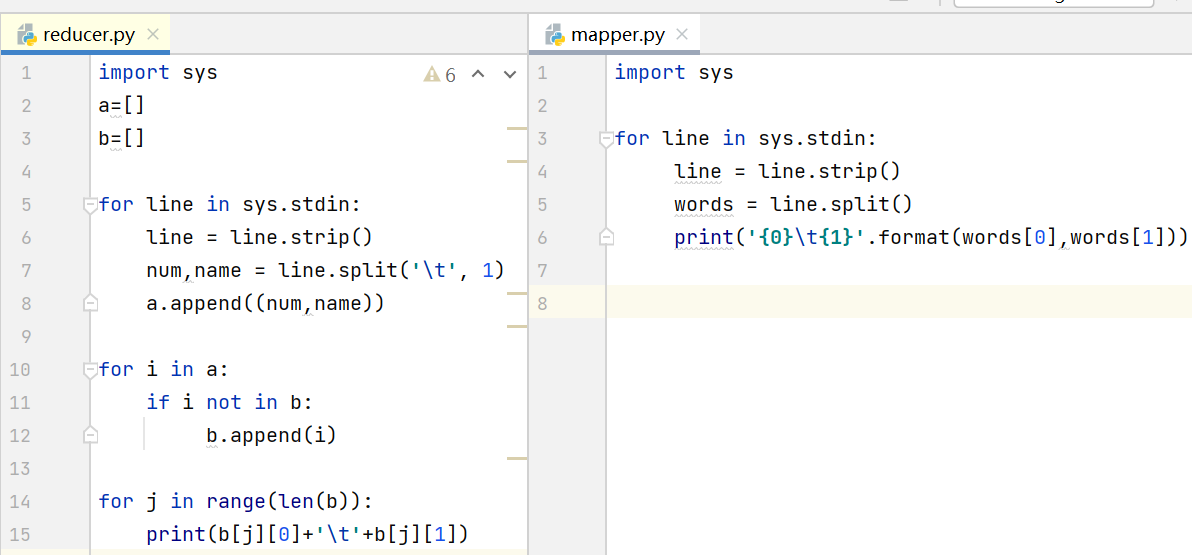

### reduceByKey word count 问题

Hadoop 中的MapReduce 实现代码：    

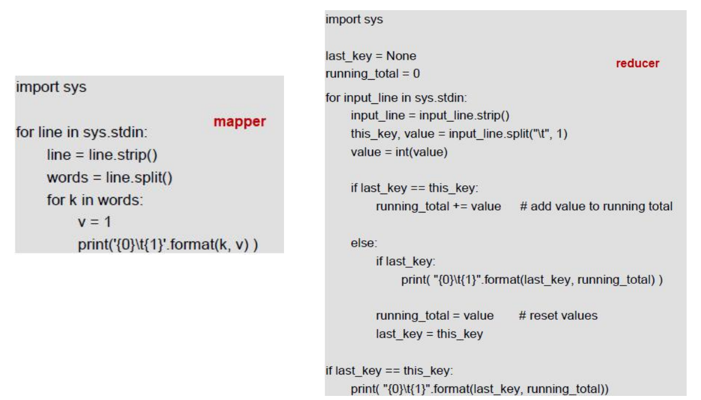

In [40]:
rdd_words.collect()

['Python hadoop spark', 'Python hadoop java', 'Python scala spark']

In [41]:
(rdd_words
 .flatMap(lambda x:x.split())
 .map(lambda x:[x,1])
).collect()

[['Python', 1],
 ['hadoop', 1],
 ['spark', 1],
 ['Python', 1],
 ['hadoop', 1],
 ['java', 1],
 ['Python', 1],
 ['scala', 1],
 ['spark', 1]]

In [42]:
(rdd_words
 .flatMap(lambda x:x.split())
 .map(lambda x:[x,1])
 .reduceByKey(lambda y,x:x+y)
).collect()

[('hadoop', 2), ('java', 1), ('Python', 3), ('spark', 2), ('scala', 1)]

## Action操作

- reduce(func)：按照func对数据进行约减
- collect()：将RDD封装成数组返回
- count():计算数据集中element的个数
- first():返回数据集中的第一个元素 
- take(n):返回前n个elements 
- takeSample(withReplacement，num，seed)：抽样返回数据集中的num个元素，随机种子seed 
- saveAsTextFile（path）：写入文本文件到path中
- saveAsSequenceFile(path):将key-value型数据保存到path中
- countByKey()：返回的是key对应的个数
- foreach(func):对dataset中的每个元素都使用func 

In [43]:
RDD_A.take(3)

['13722222222 c', '13622222222 b', '13722222222 c']

In [44]:
(rdd_words
 .flatMap(lambda x:x.split())
 .map(lambda x:[x,1])
 .countByKey())

defaultdict(int, {'Python': 3, 'hadoop': 2, 'spark': 2, 'java': 1, 'scala': 1})

### countByKey 

# 电影数据案例分析

- ratings.csv 记录了电影的评分数据
  - userId 用户ID
  - movieId 电影ID
  - rating 评分
  - timestamp 时间
  
- movies.csv 记录了电影的基本信息
  - movieId 电影ID
  - title 电影名称
  - genres 主题

## 读入数据

In [45]:
rat = sc.textFile("./data/ratings.csv")
movies = sc.textFile("./data/movies.csv")

In [46]:
rat.count()

100837

In [47]:
movies.count()

9743

## 过滤掉标题行

In [48]:
rat.take(2)

['userId,movieId,rating,timestamp', '1,1,4.0,964982703']

In [49]:
movies.take(2)

['movieId,title,genres',
 '1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy']

In [50]:
# 去掉第一行数据
rat = rat.filter(lambda x:not x.startswith("userId"))

## 计算电影的平均评分

groupByKey 根据key 对数据进行分组得到的结果如下：

```
[(key1,(v1,v2,v3,....vn)),
 (key2,(v1,v2,v3,....vn)),
 ...
 (keym,(v1,v2,v3,....vn)),
]
```

In [51]:
def get_m_k(x):
    result = x.split(",")
    return int(result[1]) ,float(result[2])

movie_avg = rat.map(get_m_k).groupByKey().map(lambda x:(x[0],sum(x[1])/len(x[1])))

In [52]:
movie_avg.take(3)

[(6, 3.946078431372549), (50, 4.237745098039215), (70, 3.5090909090909093)]

## 将电影 与 评论信息进行join关联 

处理电影数据集，包括：忽略标题行；抽取(movieId,movieName)字段
抽取出(MovieID,MovieName)

In [53]:
# 去掉标题
mov = movies.filter(lambda x:not x.startswith("movieId"))

In [54]:
# 提取电影id 及 title
def get_m_i_t(x):
    result = x.split(",")
    return int(result[0]),result[1]
mov = mov.map(get_m_i_t)

In [55]:
mov.take(2)

[(1, 'Toy Story (1995)'), (2, 'Jumanji (1995)')]

将movies_avgScore RDD和movieskey RDD进行join连接，从而得到每部电影的名称及其得分    
通过join连接,可以得到<movieId,movieName,averageRating>    
连接两个数据集,过滤评分超过4.0的电影,显示电影的ID,电影名称和平均评分    
(480, (3.75, 'Jurassic Park (1993)'))

In [56]:
mov.join(movie_avg).take(2)

[(4, ('Waiting to Exhale (1995)', 2.357142857142857)),
 (8, ('Tom and Huck (1995)', 2.875))]

In [57]:
mov.join(movie_avg).map(lambda x:(x[0],x[1][0],x[1][1])).take(2)

[(4, 'Waiting to Exhale (1995)', 2.357142857142857),
 (8, 'Tom and Huck (1995)', 2.875)]

In [58]:
spark.stop()